# Dataset
I am going to use python and further libraries to analyse the sentiment reviews, I am going to use a preconstructed annotated dataset that contains 41 399 rows.

I did some preprocessing on this data, which can be found in `find_root_sentences.py` and `divide_on_sets.py` files. The result of that is addition of three columns:
- `words` (describing words number (int))
- `roots` (describing if a sample is a root sentence, it is not a subsentence of different sentence in set (bool))
- `set_type` (describing which set it is part of {training set: 0, validation set = 1, test set: 2})

In this step I did also small cleaning, I converted the words to lower cases and removed all non-letter characters. These elements are very common and they do not provide enough semantic information for the task.

In [1245]:
import pandas as pd

In [1283]:
def ingest_train():
    data = pd.read_csv('./divided_on_sets.csv', encoding='utf-8', sep='\t')
    
    data = data[data.sentiment.isnull() == False]
    data['sentiment'] = data['sentiment'].map(int)
    
    data = data[data['tokens'].isnull() == False]
    data['tokens'] = data['tokens'].map(eval)
    
    data = data[data.roots.isnull() == False]
    data['roots'] = data['roots'].map(bool)
    
    data = data[data.words.isnull() == False]
    data['words'] = data['words'].map(int)
    data = data[data.words > 0]
    
    data = data[data.set_type.isnull() == False]
    data['set_type'] = data['set_type'].map(int)
    
    data.reset_index(inplace=True)
    data.drop('index', axis=1, inplace=True)
    data.drop('id', axis=1, inplace=True)
    return data

In [1284]:
train = ingest_train()

In [1285]:
train.describe()

,sentiment,words,set_type
count,35966.000000,35966.000000,35966.000000
mean,0.036479,4.027415,0.332453
std,0.521420,5.334304,0.678478
min,-1.000000,1.000000,0.000000
25%,0.000000,1.000000,0.000000
50%,0.000000,2.000000,0.000000
75%,0.000000,5.000000,0.000000
max,1.000000,79.000000,2.000000


In [1286]:
train.head()

,tokens,sentiment,words,roots,set_type
0,[sam],0,1,False,0
1,"[sam, burger]",0,2,False,2
2,"[sam, burger, był, dobry]",1,4,False,2
3,[dobry],1,1,False,0
4,"[sam, burger, był, dobry, oczywiście, jadła, m...",1,8,False,2


# Data visualization
Before proceeding to the classification step, I did some visualization of my textual data. The words cloud is a best choice for this matter. It displays a list of words, the importance of each beeing shown with font size or color. This format is useful for quickly perceiving the most prominent terms.

For this data viz, I used the python library wordcloud.

In [1287]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from wordcloud import WordCloud, STOPWORDS

def show_word_cloud(sentiment_val, colors):
    data = train[train.sentiment == sentiment_val]
    words = []
    for t in data.tokens:
        words += t
    words_string = " ".join(words)
    wordcloud = WordCloud(width=1600, 
                          height=800, 
                          max_font_size=200, 
                          colormap=colors, 
                          background_color='white').generate(words_string)
    plt.figure(figsize=(12,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

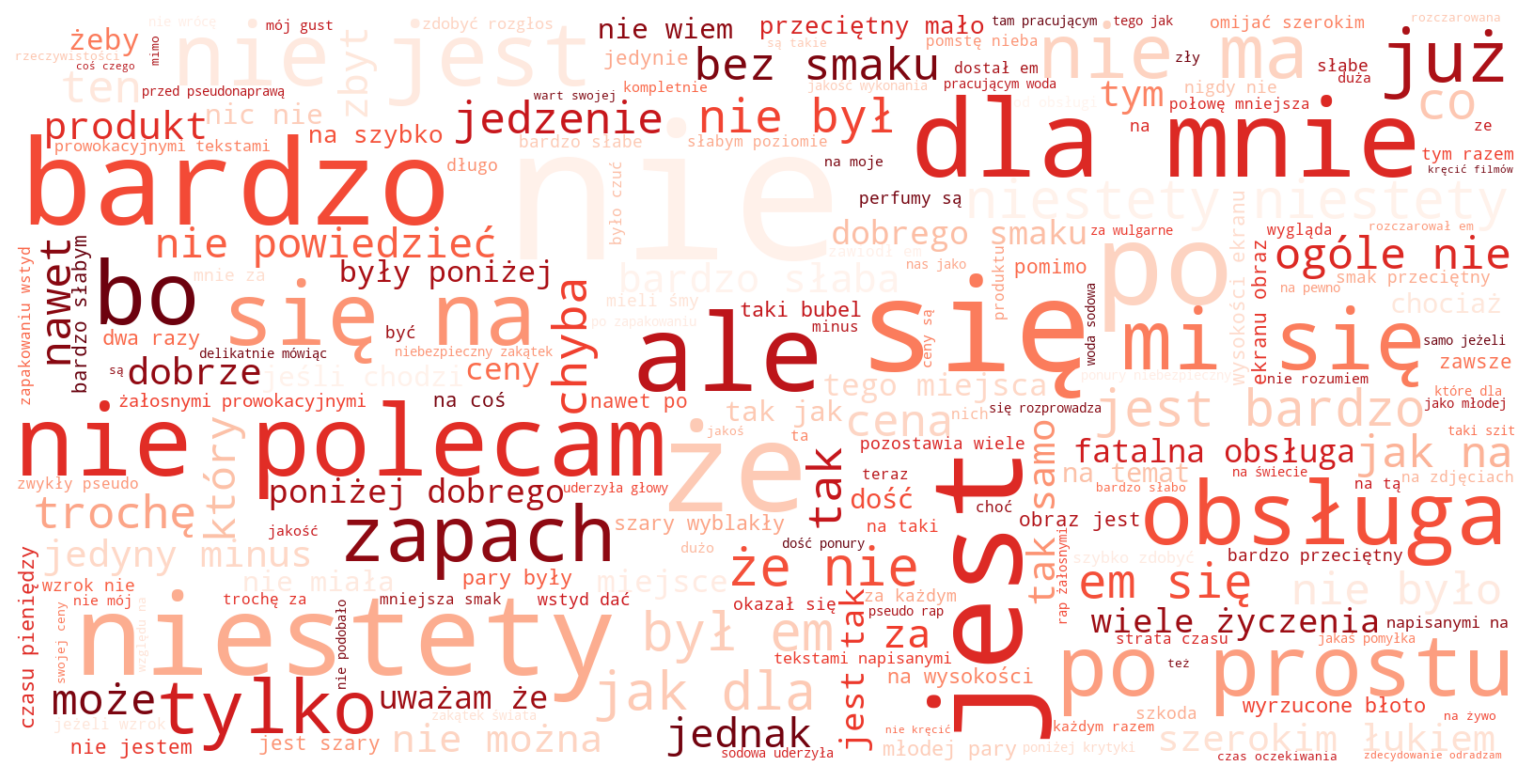

In [1288]:
show_word_cloud(-1, 'Reds')

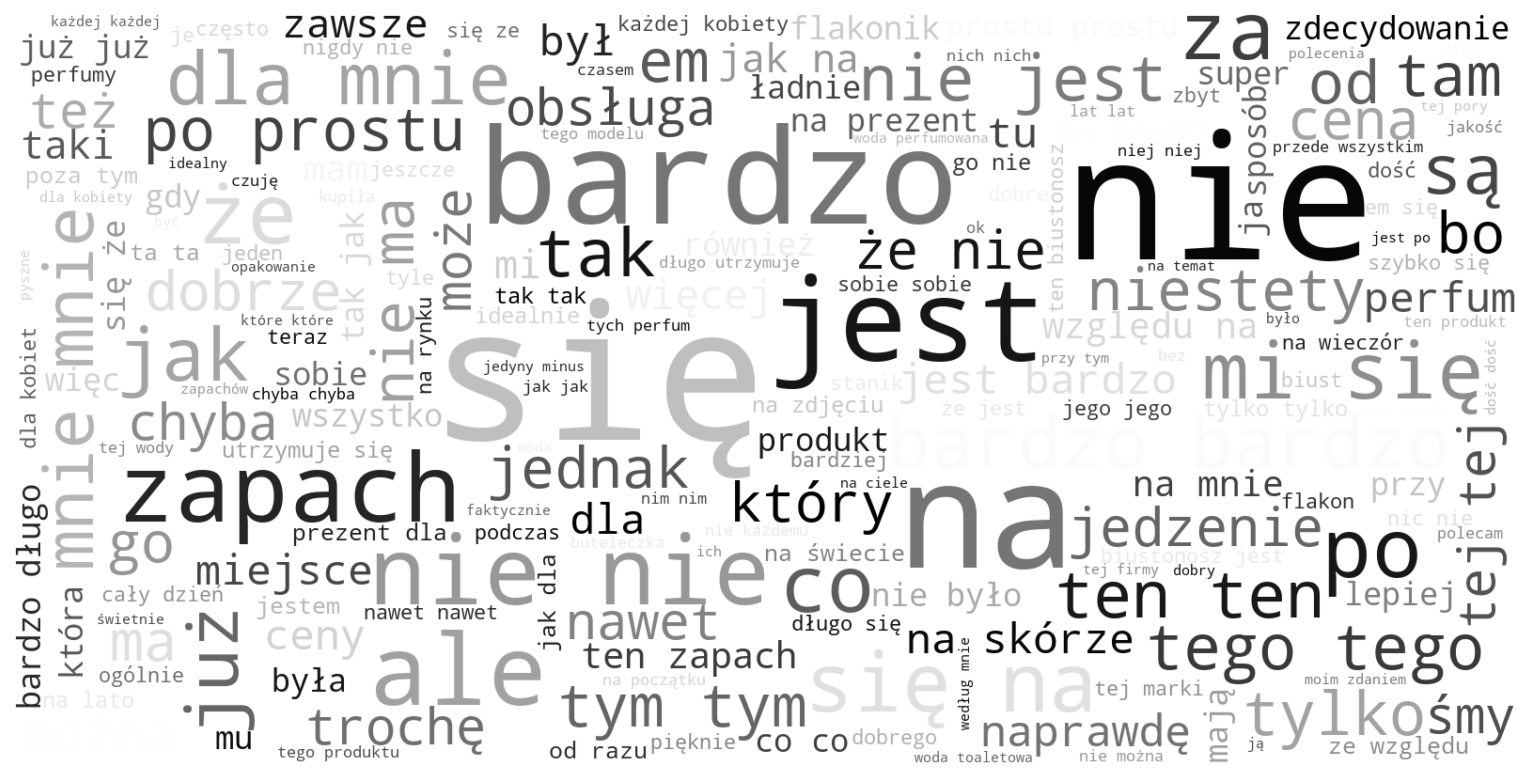

In [1289]:
show_word_cloud(0, 'gray')

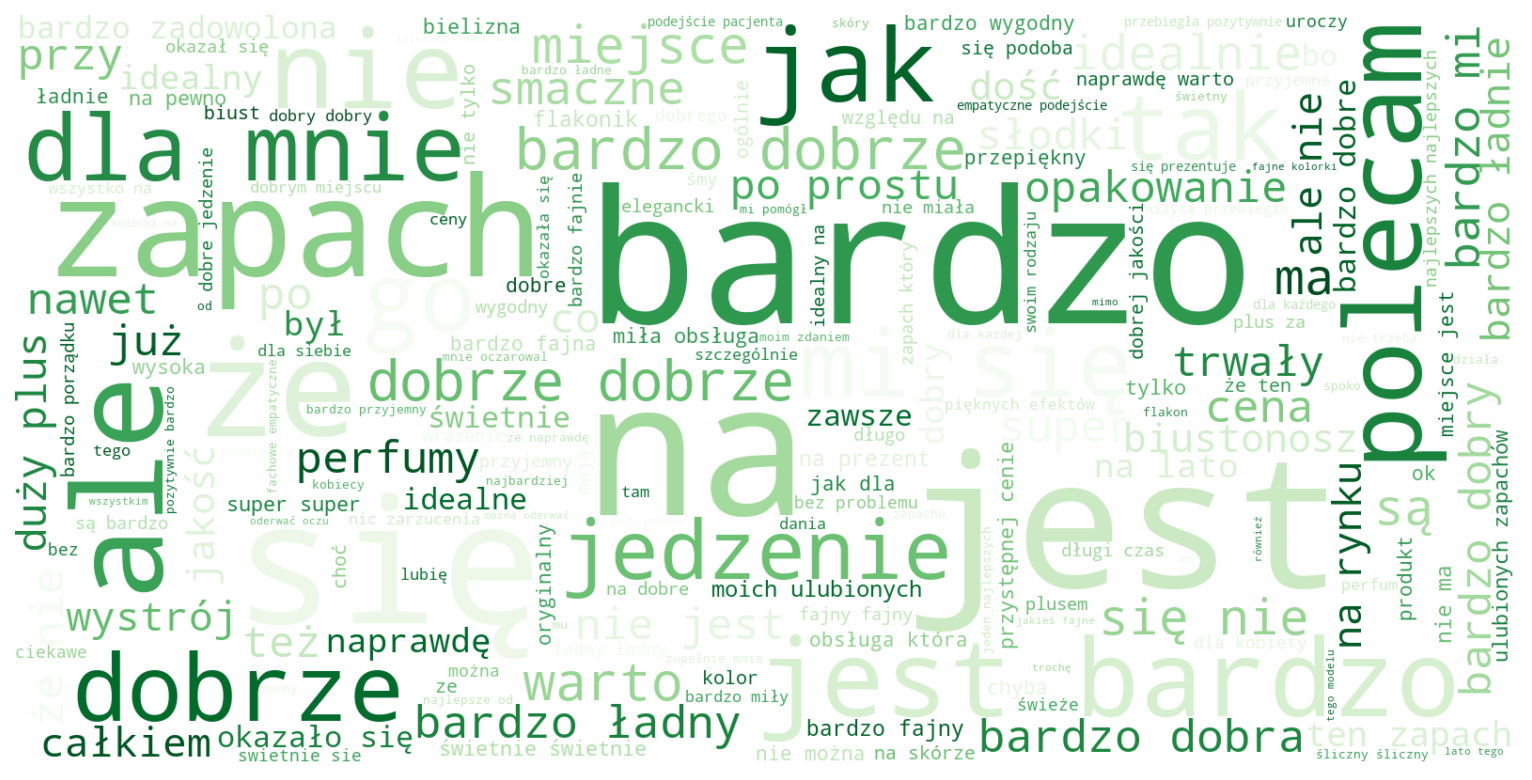

In [1290]:
show_word_cloud(1, 'Greens')

We can see some netural words in big size, "jest", "się", "bardzo" but words like "dobrze", "polecam", "ładny" are relevant for positive words and "niestety", "trochę" for negative words.

# Building the models
Before proceeding to the training phase, I split the data into training, validation and test set. I used earlier preparied `set_type` column.

In [1291]:
from sklearn.preprocessing import label_binarize

train['tokens'] = train['tokens'].map(lambda x: " ".join(x))
binary_sentiment = label_binarize(train['sentiment'], classes=[-1, 0, 1])
print(binary_sentiment[0:5])

Series([], Name: tokens, dtype: object)
[[0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]]


In [1292]:
x_train = train.tokens[train['set_type'] == 0]
x_validation = train.tokens[train['set_type'] == 1]
x_test = train.tokens[train['set_type'] == 2]

y_train = binary_sentiment[train['set_type'] == 0]
y_validation = binary_sentiment[train['set_type'] == 1]
y_test = binary_sentiment[train['set_type'] == 2]

print("train: ", len(x_train), 
      ", classes: ", 
      sum(y_train == [1, 0, 0]), sum(y_train == [0, 1, 0]), sum(y_train == [0, 0, 1]))  
print("validation: ", len(x_validation), 
      ", classes: ", 
      sum(y_validation == [1, 0, 0]), sum(y_validation == [0, 1, 0]), sum(y_validation == [0, 0, 1]))
print("test: ", len(x_test),
      ", classes: ", 
      sum(y_test == [1, 0, 0]), sum(y_test == [0, 1, 0]), sum(y_test == [0, 0, 1]))

train:  28296 , classes:  [0 0 0] [25476  6902 24214] [ 2820 21394  4082]
validation:  3383 , classes:  [0 0 0] [2758 1319 2689] [ 625 2064  694]
test:  4287 , classes:  [0 0 0] [3475 1605 3494] [ 812 2682  793]


We can see that classes are not equally distribiuted. This information will be very important in further research.
# Features Extraction
In this part, we will use a feature extraction technique called Tfidf vectorizer of 100,000 features including up to trigram. This technique is a way to convert textual data to numeric form.

In the below function, we will use a custom function that reports validation accuracy, the average precision_recall, and the time it took to train and evaluate.

In [1293]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
n_classes = 3

def multi_class_precision_recall(y_test, y_pred):
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                            y_pred[:, i])
        average_precision[i] = average_precision_score(y_test[:, i], y_pred[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(), y_pred.ravel())
    return precision["micro"], recall["micro"]

def multi_class_roc(y_test, y_pred):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    return fpr["micro"], tpr["micro"]

def multi_class_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix([np.sum(np.array([-1,0,1]) * np.array(x).T) for x in y_test], 
                         [np.sum(np.array([-1,0,1]) * np.array(x).T) for x in y_pred])
    # Normalize
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Visualize confiusion matrix as heatmap
    df_cm = pd.DataFrame(cm, index = ["-1", "0", "1"],
                  columns = ["-1", "0", "1"])
    plt.figure(figsize = (5,5))
    sn.heatmap(df_cm, annot=True, fmt='f')
    
    # Improve heatmap dispaly
    bottom, top = plt.ylim()
    bottom += 0.5
    top -= 0.5
    plt.ylim(bottom, top)
    plt.show()

In [1294]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_recall_curve, average_precision_score, roc_curve, auc
import numpy as np
from time import time

def acc_summary(pipeline, x_train, y_train, x_test, y_test):
    
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
  
    #Compute the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    #Compute the precision and recall
    precision, recall = multi_class_precision_recall(y_test, y_pred)
    #Compute the average precision
    average_precision = average_precision_score(y_test, y_pred)
  
    fpr, tpr = multi_class_roc(y_test, y_pred)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    multi_class_confusion_matrix(y_test, y_pred)
    print ("-"*80)
    return accuracy, precision, recall, average_precision, fpr, tpr

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Average precision-recall score: 0.47
accuracy score: 63.41%


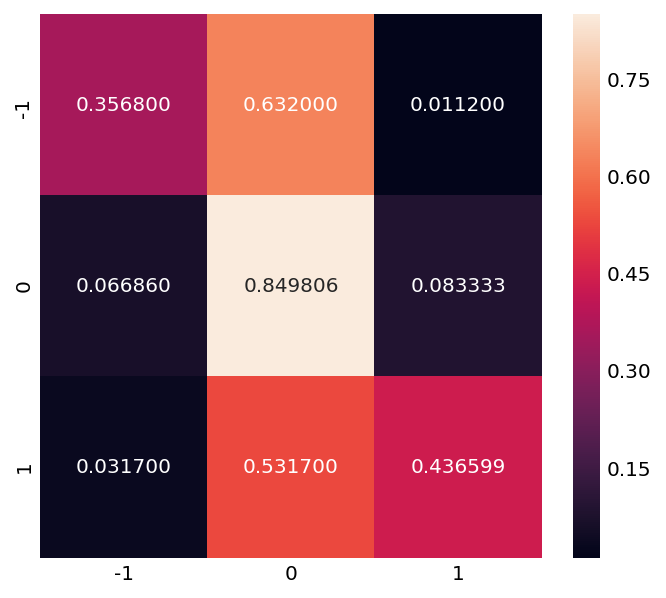

--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Average precision-recall score: 0.47
accuracy score: 65.68%


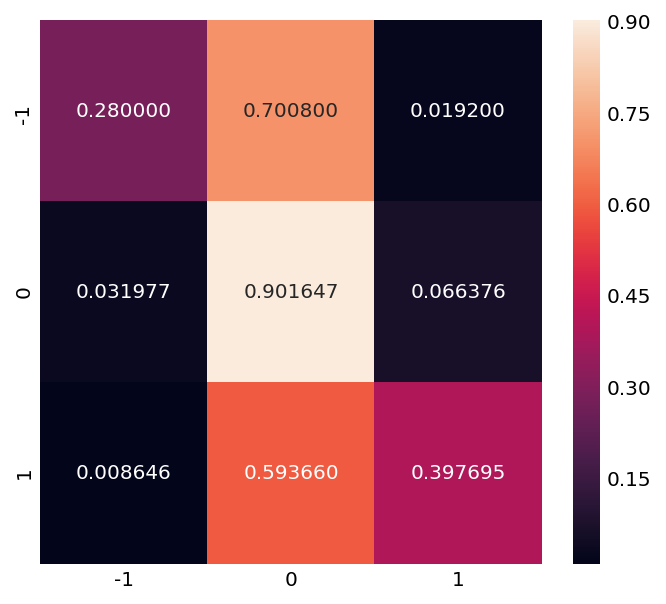

--------------------------------------------------------------------------------
Validation result for LinearSVC with L1-based feature selection
Pipeline(memory=None,
         steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(C=1.0,
                                                     class_weight='balanced',
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     loss='squared_hinge',
                                                     max_iter=1000,
                                                     multi_class='ovr',
                                                     penalty='l1',
                                                     random_state=None,
                                                     tol=0.0001, verbose=0),
              

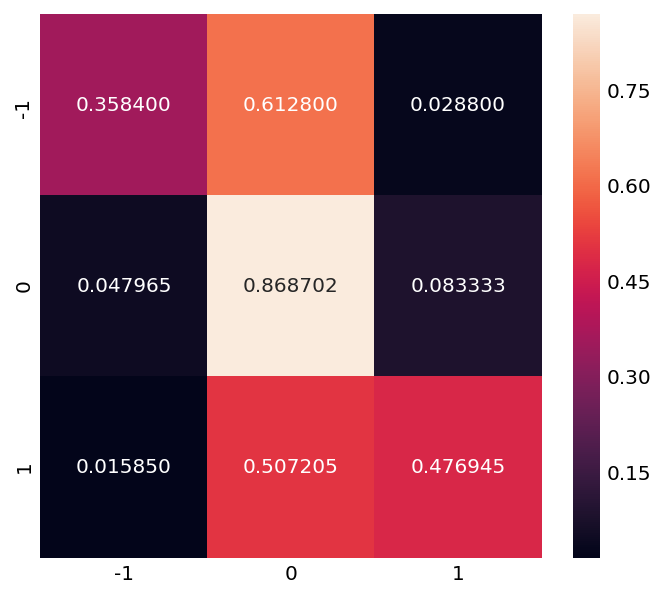

--------------------------------------------------------------------------------
Validation result for Multinomial NB
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Average precision-recall score: 0.35
accuracy score: 61.78%


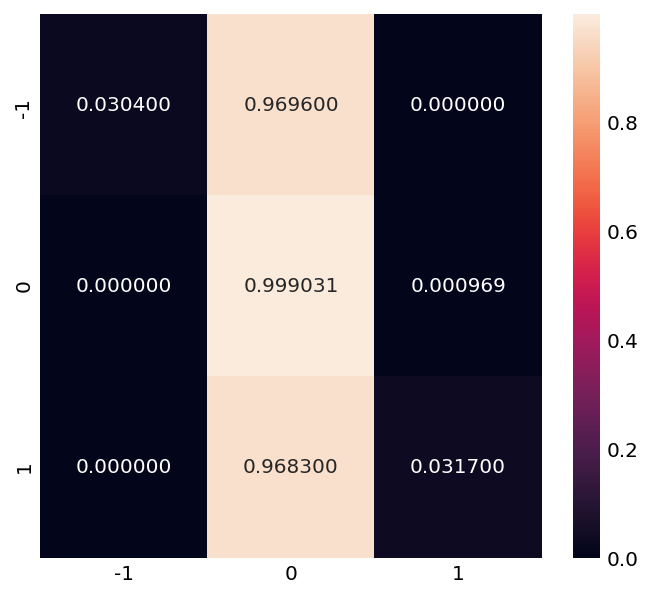

--------------------------------------------------------------------------------
Validation result for Bernoulli NB
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
Average precision-recall score: 0.37
accuracy score: 60.66%


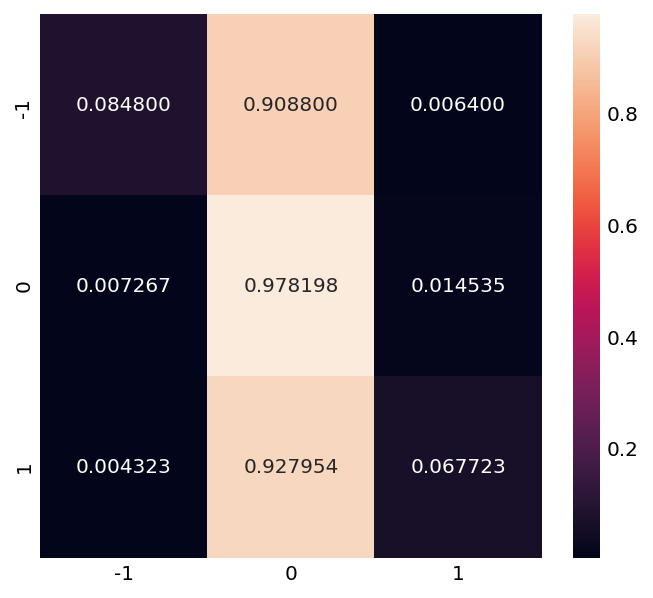

--------------------------------------------------------------------------------
Validation result for Ridge Classifier
RidgeClassifier(alpha=1.0, class_weight='balanced', copy_X=True,
                fit_intercept=True, max_iter=None, normalize=False,
                random_state=None, solver='auto', tol=0.001)
Average precision-recall score: 0.41
accuracy score: 30.65%


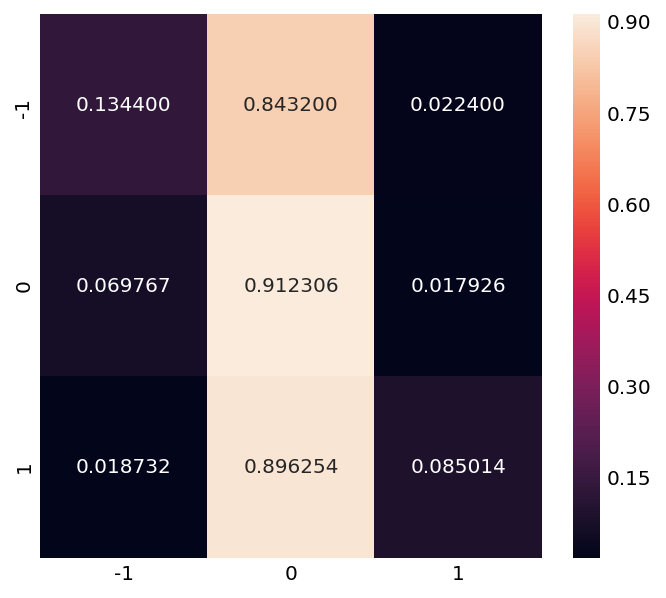

--------------------------------------------------------------------------------
Validation result for AdaBoost
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
Average precision-recall score: 0.41
accuracy score: 59.53%


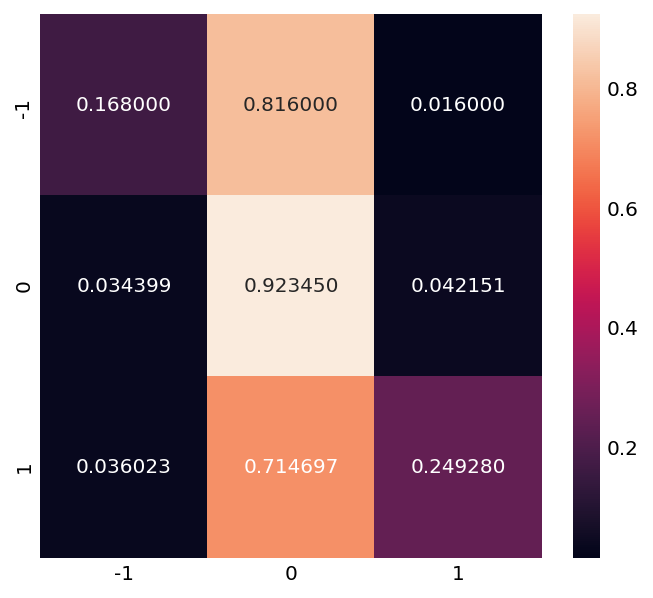

--------------------------------------------------------------------------------
Validation result for RandomForest
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Average precision-recall score: 0.44
accuracy score: 64.74%


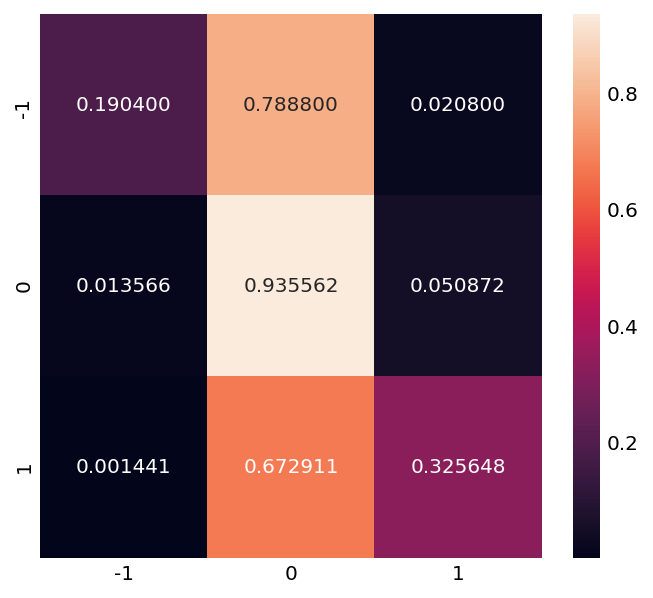

--------------------------------------------------------------------------------
Validation result for Perceptron
Perceptron(alpha=0.0001, class_weight='balanced', early_stopping=False,
           eta0=1.0, fit_intercept=True, max_iter=1000, n_iter_no_change=5,
           n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)
Average precision-recall score: 0.44
accuracy score: 62.46%


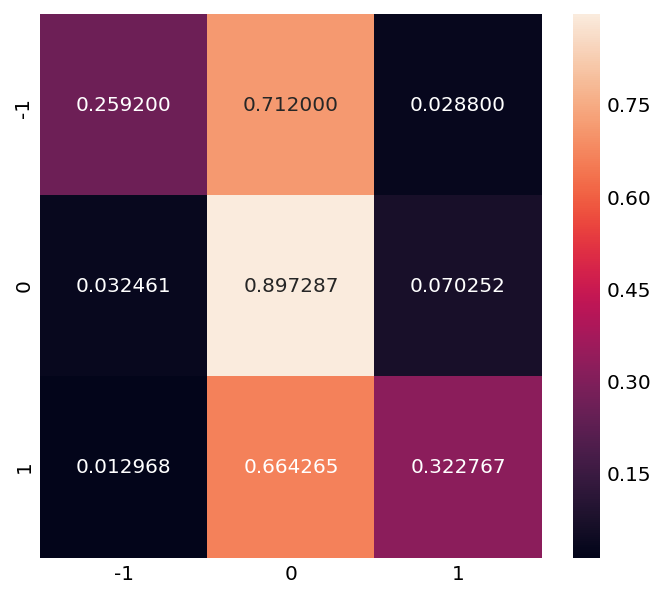

--------------------------------------------------------------------------------
Validation result for Passive-Aggresive
PassiveAggressiveClassifier(C=1.0, average=False, class_weight='balanced',
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False)
Average precision-recall score: 0.44
accuracy score: 64.20%


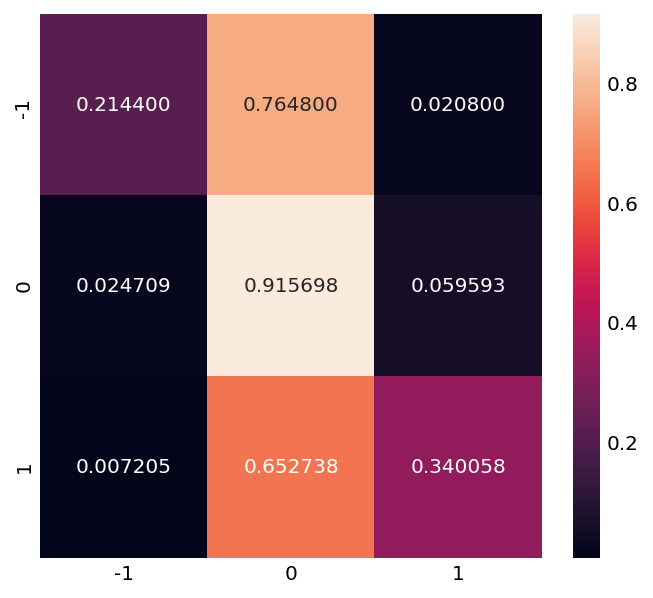

--------------------------------------------------------------------------------
Validation result for SVC RBF
SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Average precision-recall score: 0.47
accuracy score: 63.55%


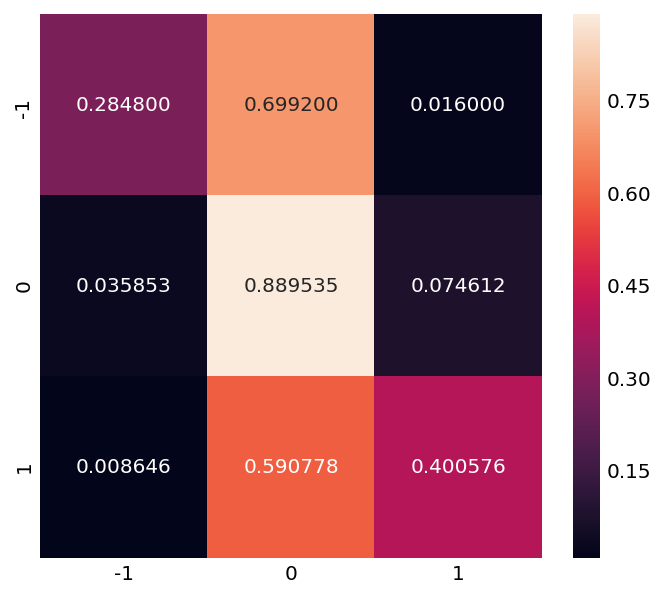

--------------------------------------------------------------------------------
Validation result for SVC RBF with L1-based feature selection
Pipeline(memory=None,
         steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(C=1.0,
                                                     class_weight='balanced',
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     loss='squared_hinge',
                                                     max_iter=1000,
                                                     multi_class='ovr',
                                                     penalty='l1',
                                                     random_state=None,
                                                     tol=0.0001, verbose=0),
                

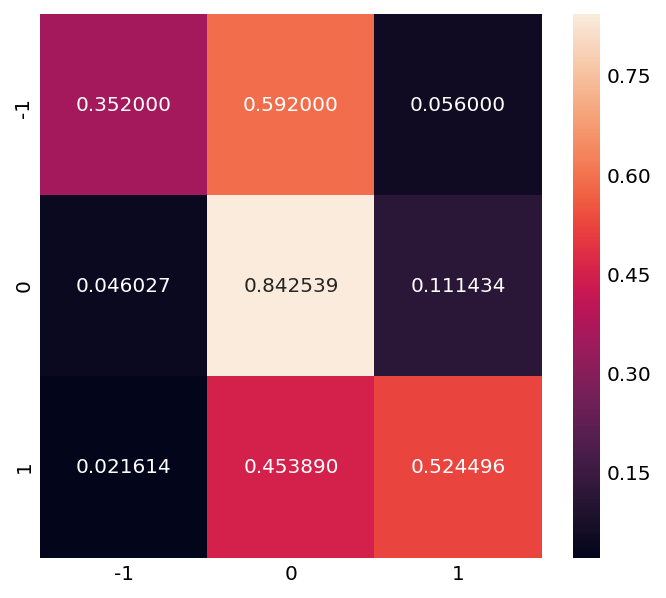

--------------------------------------------------------------------------------


In [1295]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier, PassiveAggressiveClassifier, Perceptron, LogisticRegression
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel
from sklearn.multiclass import OneVsRestClassifier

names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "AdaBoost", "RandomForest", "Perceptron","Passive-Aggresive", 
         "SVC RBF", "SVC RBF with L1-based feature selection"]
classifiers = [
    LogisticRegression(class_weight='balanced', max_iter=1000),
    LinearSVC(class_weight='balanced'),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, class_weight='balanced'))),
  ('classification', LinearSVC(penalty="l2", class_weight='balanced'))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(class_weight='balanced'),
    AdaBoostClassifier(),
    RandomForestClassifier(),
    Perceptron(class_weight="balanced"),
    PassiveAggressiveClassifier(class_weight='balanced'),
    SVC(class_weight='balanced'),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, class_weight='balanced'))),
  ('classification', SVC(class_weight='balanced'))]),
    ]
zipped_clf = zip(names,classifiers)

vec = TfidfVectorizer(min_df=0)

def classifier_comparator(vectorizer=vec, n_features=10000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', OneVsRestClassifier(c))
        ])
        print ("Validation result for {}".format(n))
        print (c)
        clf_acc, prec, rec, avg, fp, tp = acc_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,clf_acc,prec, rec, avg, fp, tp))
    return result

result = classifier_comparator(n_features=100000, ngram_range=(1, 3))

Now we plot the summary of this comparison like below, namely the accuracy of each model, their train and test time, and their average precision.

In [1302]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import numpy as np

def bar_plot(result):
    acc=[]
    names = []
    avg_ = []
    fp_ = []
    tp_ = []

    for name, accuracy, prec, rec, avg, fp, tp in result:
        acc.append(accuracy*100)
        names.append(name)

        avg_.append(avg*100)
        fp_.append(fp)
        tp_.append(tp)
    trace1 = go.Bar(
        x=names,
        y=acc,
        name='Accuracy percentage (%)'
    )
    trace3 = go.Bar(
        x=names,
        y=avg_,
        name='Average precision (%)'
    )


    data = [trace1, trace3]
    layout = go.Layout(
        barmode='group'
    )

    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename='grouped-bar')
    return names, fp_, tp_

In [1303]:
names, fp_, tp_ = bar_plot(result)

We can show furthermore the performance of our classifiers by using the ROC Curve technique. This curve plots two parameters: True Positive Rate, False Positive Rate

In [1306]:
def ROC_curve(names, fp, tp):
    data = []
    for i in range(0, len(names)):
        trace = go.Scatter(x=fp[i], y=tp[i],
                            mode='lines', 
                            name='ROC curve {}'
                                   ''.format(names[i]))
        data.append(trace)

    layout = go.Layout(title='Receiver operating characteristic ',
                       xaxis=dict(title='False Positive Rate'),
                       yaxis=dict(title='True Positive Rate'))

    fig = go.Figure(data=data, layout=layout)
    return fig

In [1307]:
fig = ROC_curve(names, fp_, tp_)
py.iplot(fig)

Validation result for LinearSVC with L1-based feature selection
Pipeline(memory=None,
         steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(C=1.0,
                                                     class_weight='balanced',
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     loss='squared_hinge',
                                                     max_iter=1000,
                                                     multi_class='ovr',
                                                     penalty='l1',
                                                     random_state=None,
                                                     tol=0.0001, verbose=0),
                                 max_features=None, norm_order=1, prefit=False,
               

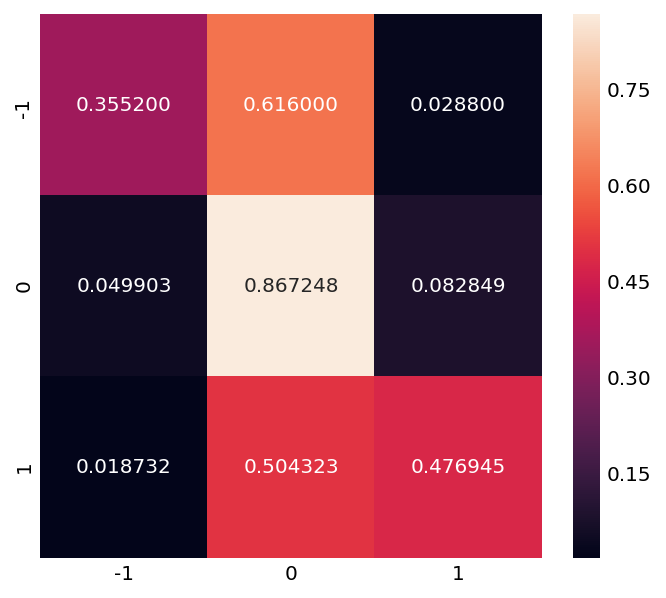

Average precision-recall score: 0.49
accuracy score: 65.33%
--------------------------------------------------------------------------------
Validation result for SVC RBF with L1-based feature selection
Pipeline(memory=None,
         steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(C=1.0,
                                                     class_weight='balanced',
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     loss='squared_hinge',
                                                     max_iter=1000,
                                                     multi_class='ovr',
                                                     penalty='l1',
                                                     random_state=None,
                                 

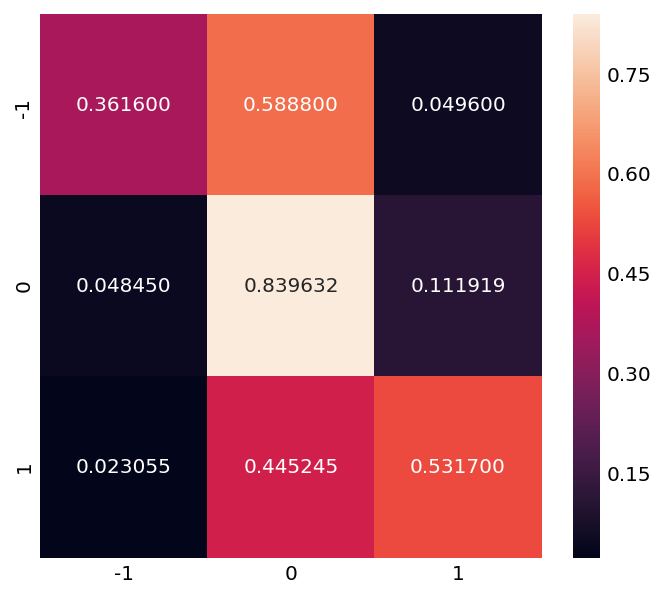

Average precision-recall score: 0.49
accuracy score: 64.85%
--------------------------------------------------------------------------------


In [1235]:
chosen_names = ["LinearSVC with L1-based feature selection", 
         "SVC RBF with L1-based feature selection"]
chosen_classifiers = [
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, class_weight='balanced'))),
  ('classification', LinearSVC(penalty="l2", class_weight='balanced'))]),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, class_weight='balanced'))),
  ('classification', SVC(class_weight='balanced'))]),
    ]
chosen_zipped_clf = zip(chosen_names, chosen_classifiers)

result = classifier_comparator(n_features=100000,ngram_range=(1,3), classifier=chosen_zipped_clf)

In [1238]:
x_train_val = train[(train['set_type'] == 0) | (train['set_type'] == 1)]
y_train_val = train.sentiment[(train['set_type'] == 0) | (train['set_type'] == 1)]

train_indeces = np.array([i for i in range(len(x_train_val))])
train_indeces = train_indeces[x_train_val.set_type == 0]
validation_indeces = np.array([i for i in range(len(x_train_val))])
validation_indeces = validation_indeces[x_train_val['set_type'] == 1]

x_train_val = x_train_val.tokens

print("train: ", len(train_indeces), ", validation: ", len(validation_indeces))

train:  28296 , validation:  3383


In [1239]:
from sklearn.model_selection import GridSearchCV

vectorizer = TfidfVectorizer(min_df=0)
vectorizer.set_params(stop_words=None, max_features=100000, ngram_range=(1,3))

parameters = {'svc__estimator__kernel':('linear', 'poly', 'rbf', 'sigmoid', 'precomputed'), 
              'svc__estimator__C':[1, 2, 5, 10],
              'svc__estimator__gamma':('scale', 'auto')}

pipe = Pipeline([
        ('vectorizer', vectorizer),
        ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, class_weight='balanced'))),
        ('svc', OneVsRestClassifier(SVC(class_weight='balanced')))])

search = GridSearchCV(pipe, 
                      param_grid=parameters, 
                      n_jobs=-1,
                      cv=[(train_indeces, validation_indeces)])
search.fit(x_train_val, y_train_val)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

sorted(search.cv_results_.keys())

/home/asia/venv/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Best parameter (CV score=0.699):
{'svc__estimator__C': 1, 'svc__estimator__gamma': 'scale', 'svc__estimator__kernel': 'rbf'}


['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_svc__estimator__C',
 'param_svc__estimator__gamma',
 'param_svc__estimator__kernel',
 'params',
 'rank_test_score',
 'split0_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [1241]:
from sklearn.model_selection import GridSearchCV

vectorizer = TfidfVectorizer(min_df=0)
vectorizer.set_params(stop_words=None, max_features=100000, ngram_range=(1,3))

parameters = {'svc__estimator__kernel':('linear', 'poly', 'rbf', 'sigmoid', 'precomputed'), 
              'svc__estimator__C':[1, 2, 5, 10],
              'svc__estimator__gamma':('scale', 'auto')}

pipe = Pipeline([
        ('vectorizer', vectorizer),
        ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, class_weight='balanced'))),
        ('svc', OneVsRestClassifier(SVC(class_weight='balanced')))])

search = GridSearchCV(pipe, 
                      param_grid=parameters, 
                      n_jobs=-1,
                      cv=[(train_indeces, validation_indeces)],
                      scoring='f1_weighted')
search.fit(x_train_val, y_train_val)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

sorted(search.cv_results_.keys())

/home/asia/venv/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Best parameter (CV score=0.689):
{'svc__estimator__C': 1, 'svc__estimator__gamma': 'scale', 'svc__estimator__kernel': 'rbf'}


['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_svc__estimator__C',
 'param_svc__estimator__gamma',
 'param_svc__estimator__kernel',
 'params',
 'rank_test_score',
 'split0_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [1243]:
from sklearn.model_selection import GridSearchCV

vectorizer = TfidfVectorizer(min_df=0)
vectorizer.set_params(stop_words=None, max_features=100000, ngram_range=(1,3))

parameters = {'svc__estimator__penalty':('l1', 'l2'), 
              'svc__estimator__loss':('hinge', 'squared_hinge'),
              'svc__estimator__C':[1, 2, 5, 10],
              'svc__estimator__max_iter':(1000, 2000, 5000, 10000),
             }

pipe = Pipeline([
        ('vectorizer', vectorizer),
        ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, class_weight='balanced'))),
        ('svc', OneVsRestClassifier(LinearSVC(class_weight='balanced')))])

search = GridSearchCV(pipe, 
                      param_grid=parameters, 
                      n_jobs=-1,
                      cv=[(train_indeces, validation_indeces)])
search.fit(x_train_val, y_train_val)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.695):
{'svc__estimator__C': 1, 'svc__estimator__loss': 'hinge', 'svc__estimator__max_iter': 10000, 'svc__estimator__penalty': 'l2'}


In [1244]:
from sklearn.model_selection import GridSearchCV

vectorizer = TfidfVectorizer(min_df=0)
vectorizer.set_params(stop_words=None, max_features=100000, ngram_range=(1,3))

parameters = {'svc__estimator__penalty':('l1', 'l2'), 
              'svc__estimator__loss':('hinge', 'squared_hinge'),
              'svc__estimator__C':[1, 2, 5, 10],
              'svc__estimator__max_iter':(1000, 2000, 5000, 10000),
             }

pipe = Pipeline([
        ('vectorizer', vectorizer),
        ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, class_weight='balanced'))),
        ('svc', OneVsRestClassifier(LinearSVC(class_weight='balanced')))])

search = GridSearchCV(pipe, 
                      param_grid=parameters, 
                      n_jobs=-1,
                      cv=[(train_indeces, validation_indeces)],
                      scoring='f1_weighted')
search.fit(x_train_val, y_train_val)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.683):
{'svc__estimator__C': 1, 'svc__estimator__loss': 'hinge', 'svc__estimator__max_iter': 5000, 'svc__estimator__penalty': 'l2'}


/home/asia/venv/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



Validation result for LinearSVC with L1-based feature selection
Pipeline(memory=None,
         steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(C=1.0,
                                                     class_weight='balanced',
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     loss='squared_hinge',
                                                     max_iter=1000,
                                                     multi_class='ovr',
                                                     penalty='l1',
                                                     random_state=None,
                                                     tol=0.0001, verbose=0),
                                 max_features=None, norm_order=1, prefit=False,
               

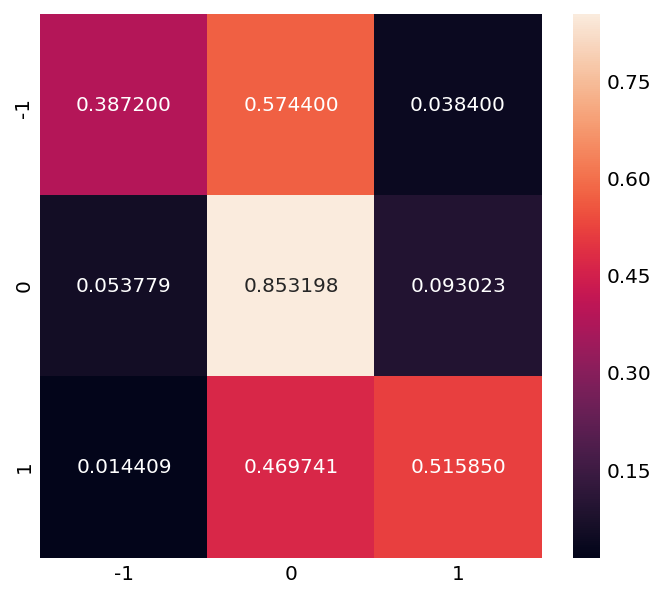

--------------------------------------------------------------------------------
Validation result for SVC RBF with L1-based feature selection
Pipeline(memory=None,
         steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(C=1.0,
                                                     class_weight='balanced',
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     loss='squared_hinge',
                                                     max_iter=1000,
                                                     multi_class='ovr',
                                                     penalty='l1',
                                                     random_state=None,
                                                     tol=0.0001, verbose=0),
                

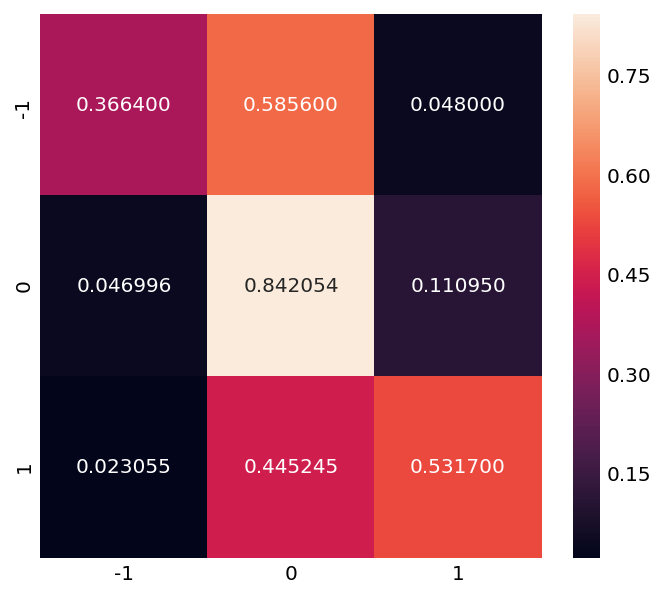

--------------------------------------------------------------------------------


In [1308]:
tuned_names = ["LinearSVC with L1-based feature selection", 
         "SVC RBF with L1-based feature selection"]
tuned_classifiers = [
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, class_weight='balanced'))),
  ('classification', LinearSVC(penalty="l2", class_weight='balanced', C=1, loss='hinge', max_iter=5000))]),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, class_weight='balanced'))),
  ('classification', SVC(C=1, gamma='scale', kernel='rbf', class_weight='balanced'))]),
    ]
tuned_zipped_clf = zip(tuned_names, tuned_classifiers)

tuned_result = classifier_comparator(n_features=100000,ngram_range=(1, 3), classifier=tuned_zipped_clf)

In [1309]:
tuned_names, tuned_fp, tuned_tp = bar_plot(tuned_result)

In [1310]:
tuned_fig = ROC_curve(tuned_names, tuned_fp, tuned_tp)
py.iplot(tuned_fig)

Validation result for LinearSVC with L1-based feature selection
Pipeline(memory=None,
         steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(C=1.0,
                                                     class_weight='balanced',
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     loss='squared_hinge',
                                                     max_iter=1000,
                                                     multi_class='ovr',
                                                     penalty='l1',
                                                     random_state=None,
                                                     tol=0.0001, verbose=0),
                                 max_features=None, norm_order=1, prefit=False,
               

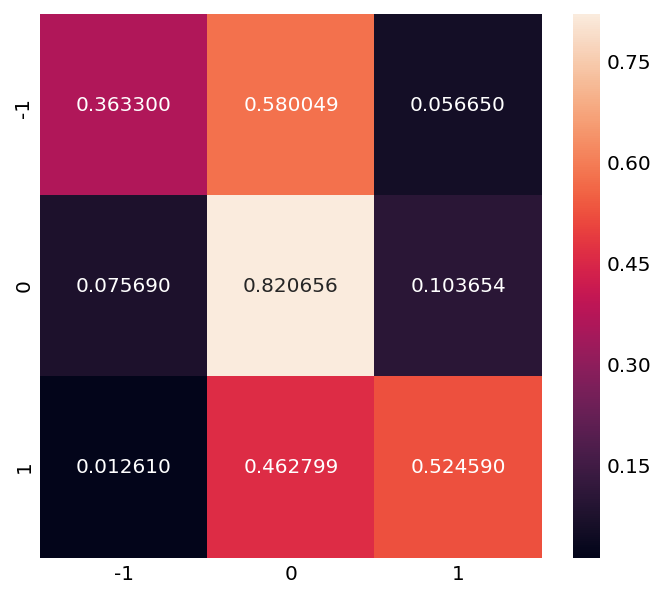

--------------------------------------------------------------------------------
Validation result for SVC RBF with L1-based feature selection
Pipeline(memory=None,
         steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(C=1.0,
                                                     class_weight='balanced',
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     loss='squared_hinge',
                                                     max_iter=1000,
                                                     multi_class='ovr',
                                                     penalty='l1',
                                                     random_state=None,
                                                     tol=0.0001, verbose=0),
                

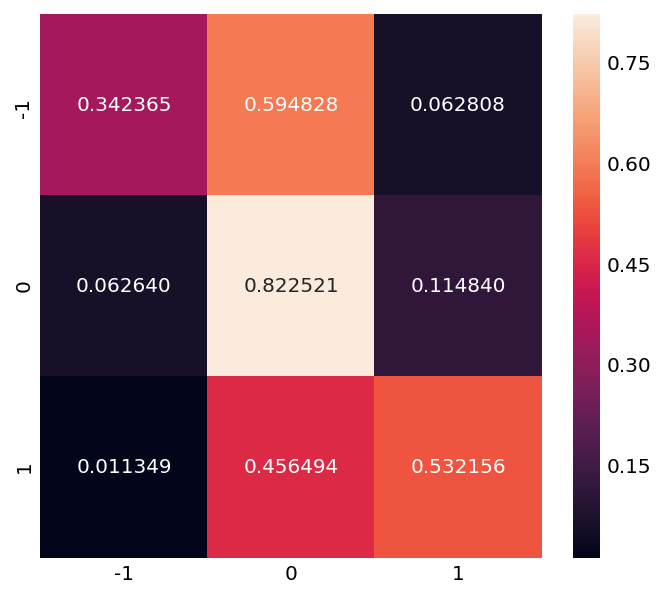

--------------------------------------------------------------------------------


In [1317]:
tuned_names = ["LinearSVC with L1-based feature selection", 
         "SVC RBF with L1-based feature selection"]
tuned_classifiers = [
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, class_weight='balanced'))),
  ('classification', LinearSVC(penalty="l2", class_weight='balanced', C=1, loss='hinge', max_iter=5000))]),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, class_weight='balanced'))),
  ('classification', SVC(C=1, gamma='scale', kernel='rbf', class_weight='balanced'))]),
    ]
tuned_zipped_clf = zip(tuned_names, tuned_classifiers)

def classifier_comparator_2(vectorizer=vec, n_features=10000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', OneVsRestClassifier(c))
        ])
        print ("Validation result for {}".format(n))
        print (c)
        clf_acc, prec, rec, avg, fp, tp = acc_summary(checker_pipeline, 
                                                      train[train['set_type'] != 2].tokens, 
                                                      binary_sentiment[train['set_type'] != 2], 
                                                      train[train['set_type'] == 2].tokens, 
                                                      binary_sentiment[train['set_type'] == 2])
        result.append((n,clf_acc,prec, rec, avg, fp, tp))
    return result

tuned_result = classifier_comparator_2(n_features=100000,ngram_range=(1, 3), classifier=tuned_zipped_clf)